In [1]:
import warnings
import os 
from pathlib import Path
import pandas as pd 
from logbook import Logger, StderrHandler, INFO, WARNING
import numpy as np 

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order, set_benchmark, symbol,
                         set_long_only
                        )
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import KR_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.factors import AverageDollarVolume, Returns
from zipline.pipeline.loaders import KREquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [2]:
warnings.filterwarnings('ignore')

## Load Zipline Extension

In [3]:
os.environ['ZIPLINE_ROOT'] = 'C:/Users/PC/.zipline/'

In [4]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [5]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [6]:
N_LONGS = 20
VOL_SCREEN = 650

## Load DataReader Bundles

In [7]:
bundle_data = bundles.load('fnguide')

In [8]:
idx = pd.IndexSlice

In [9]:
def load_factor(bundle):
    with pd.HDFStore('../factor.h5') as store: 
        factor = (store['value/pcr']
                   .loc[idx['2000':'2021', :], :]
                  )
        factor = factor[factor['Ratio'] > 0]
    tickers = factor.index.get_level_values('ticker').unique().tolist()
    
    assets = []
    for ticker in tickers:
        try:
            asset = bundle.asset_finder.lookup_symbol(ticker, as_of_date=None)
            assets.append(asset)
        except Exception as e:
            print(e)
    factor_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, factor_sids))
    return (factor
            .unstack('ticker')
            .rename(columns=ticker_map)
            .Ratio
            .tz_localize('UTC')
            .fillna(method='ffill')
           ), assets

In [10]:
pcr, assets = load_factor(bundle_data)

In [11]:
pcr 

ticker,32,36,42,48,50,56,74,75,89,107,...,1139,1144,530,1143,1101,1145,1133,1148,1149,1150
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,0.610161,3.914366,0.404982,2.672288,2.458299,9.201085,0.835577,1.946182,6.744913,0.501054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04 00:00:00+00:00,0.656397,4.092261,0.446453,2.620178,2.479675,10.294029,0.835577,2.013407,7.274847,0.522146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05 00:00:00+00:00,0.688746,3.985491,0.422875,2.478547,2.171869,9.785682,0.803440,2.083952,6.889432,0.847591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06 00:00:00+00:00,0.651768,3.736470,0.417175,2.513955,2.214621,8.997743,0.795405,1.999962,6.484748,0.804988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07 00:00:00+00:00,0.647139,3.878885,0.417175,2.443139,2.265914,9.353584,0.759251,2.299069,6.600363,0.821375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20 00:00:00+00:00,9.935930,0.304598,3.286003,43.306655,6.519004,15.132104,72.773045,11.071496,1.226827,27.672855,...,8.810488,28.121817,45.920438,27.050067,183.975000,119.645264,79.247475,96.793452,5.856130,7.177424
2021-07-21 00:00:00+00:00,9.935930,0.304598,3.244316,42.835034,6.519004,15.132104,72.773045,11.169474,1.226827,26.827885,...,8.810488,27.904835,45.920438,26.479932,189.015930,119.645264,77.025583,96.070026,5.915483,7.189491
2021-07-22 00:00:00+00:00,9.935930,0.304598,3.240516,43.070845,6.519004,15.132104,72.773045,11.169474,1.226827,26.968723,...,8.810488,27.948231,45.920438,27.366831,217.578228,119.645264,77.025583,94.333819,5.955052,7.249826


## Define Custom Dataset

In [12]:
class PCRData(DataSet):
    ratio = Column(dtype=float)
    domain = KR_EQUITIES

## Define Pipeline Loaders

In [13]:
pcr_loader = {PCRData.ratio: DataFrameLoader(PCRData.ratio, pcr)}

## Pipeline & Setup

In [14]:
class PCR(CustomFactor):
    inputs = [PCRData.ratio]
    window_length = 1
    
    def compute(self, today, assets, out, pcr):
        out[:] = pcr

## Create Pipeline

In [15]:
def compute_factors():
    pcr = PCR()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={
        'longs': pcr.bottom(N_LONGS),
        'ranking': pcr.rank(ascending=False),
        },
        screen=dollar_volume.top(600)
    )

## Initialize Algorithm

In [16]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

In [17]:
def rebalance(context, data):
    print(context.datetime)
    factor_data = pipeline_output('factor_pipeline')
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    divest = set(context.portfolio.positions.keys()) - set(longs)

    # 보유 주식 처분
    exec_trades(data, assets=divest, target_percent=0)
    # 새롭게 리밸런싱
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)

In [18]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.universe = assets
    context.longs = 0
    set_long_only()
    set_benchmark(symbol('kospi'))
    set_slippage(slippage.FixedSlippage(spread=0.01))
    set_commission(commission.PerShare(cost=0.002, min_trade_cost=0))

    attach_pipeline(pipeline=compute_factors(), name='factor_pipeline')
    schedule_function(rebalance,
                      date_rules.month_end(),
                      time_rules.market_close())       

In [19]:
start = pd.Timestamp('2000-01-01', tz='utc')
end = pd.Timestamp('2021-07-01', tz='utc')

## Start BackTest

In [20]:
results = run_algorithm(start=start,
                        end=end,
                        initialize=initialize,
                        capital_base=1e6,
                        data_frequency='daily',
                        bundle='fnguide',
                        trading_calendar=get_calendar('XKRX'),
                        custom_loader=pcr_loader
                       )

2000-01-31 06:30:00+00:00
2000-02-29 06:30:00+00:00
2000-03-31 06:30:00+00:00
2000-04-28 06:30:00+00:00
2000-05-31 06:30:00+00:00
2000-06-30 06:30:00+00:00
2000-07-31 06:30:00+00:00
2000-08-31 06:30:00+00:00
2000-09-29 06:30:00+00:00
2000-10-31 06:30:00+00:00
2000-11-30 06:30:00+00:00
2000-12-26 06:30:00+00:00
2001-01-31 06:30:00+00:00
2001-02-28 06:30:00+00:00
2001-03-30 06:30:00+00:00
2001-04-30 06:30:00+00:00
2001-05-31 06:30:00+00:00
2001-06-29 06:30:00+00:00
2001-07-31 06:30:00+00:00
2001-08-31 06:30:00+00:00
2001-09-28 06:30:00+00:00
2001-10-31 06:30:00+00:00
2001-11-30 06:30:00+00:00
2001-12-28 06:30:00+00:00
2002-01-31 06:30:00+00:00
2002-02-28 06:30:00+00:00
2002-03-29 06:30:00+00:00
2002-04-30 06:30:00+00:00
2002-05-31 06:30:00+00:00
2002-06-28 06:30:00+00:00
2002-07-31 06:30:00+00:00
2002-08-30 06:30:00+00:00
2002-09-30 06:30:00+00:00
2002-10-31 06:30:00+00:00
2002-11-29 06:30:00+00:00
2002-12-30 06:30:00+00:00
2003-01-30 06:30:00+00:00
2003-02-28 06:30:00+00:00
2003-03-31 0

## PyFolio Analysis

In [21]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [22]:
benchmark_period_returns = results['benchmark_period_return']
benchmark = np.exp(np.log(benchmark_period_returns + 1.0).diff()) - 1.0

## Tear Sheets

Start date,2000-01-04
End date,2021-07-01
Total months,252
,Backtest
Annual return,7.482%
Cumulative returns,357.274%
Annual volatility,21.404%
Sharpe ratio,0.44
Calmar ratio,0.12
Stability,0.45
Max drawdown,-63.022%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,63.02,2007-07-23,2020-03-23,NaT,NaN
1,48.60,2002-01-31,2003-03-17,2005-07-06,895
2,32.29,2000-08-31,2000-12-26,2002-01-07,353
3,21.36,2000-03-13,2000-05-23,2000-07-10,86
4,17.01,2006-05-11,2006-08-07,2007-02-15,201


Stress Events,mean,min,max
Dotcom,0.20%,-5.42%,7.82%
Lehman,-0.25%,-5.99%,3.77%
9/11,-0.42%,-11.87%,7.73%
US downgrade/European Debt Crisis,-0.50%,-3.88%,3.20%
Fukushima,-0.16%,-4.75%,0.80%
US Housing,-0.19%,-3.39%,3.02%
EZB IR Event,-0.57%,-12.96%,1.92%
Aug07,-0.08%,-8.33%,5.17%
Mar08,-0.25%,-2.30%,1.59%
Sept08,-0.06%,-5.99%,3.77%


Top 10 long positions of all time,max
sid,
013200,19.59%
000420,19.21%
005610,17.18%
117930,16.89%
005010,14.78%
005980,12.90%
003660,11.75%
002990,11.09%
015110,10.92%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
013200,19.59%
000420,19.21%
005610,17.18%
117930,16.89%
005010,14.78%
005980,12.90%
003660,11.75%
002990,11.09%
015110,10.92%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,1415.00,7.00,1408.00
Percent profitable,0.60,0.00,0.61
Winning round_trips,853.00,0.00,853.00
Losing round_trips,562.00,7.00,555.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$3572919.01,$-0.09,$3572919.10
Gross profit,$15243273.77,$0.00,$15243273.77
Gross loss,$-11670354.76,$-0.09,$-11670354.67
Profit factor,$1.31,$0.00,$1.31
Avg. trade net profit,$2525.03,$-0.01,$2537.58
Avg. winning trade,$17870.19,NaN,$17870.19
Avg. losing trade,$-20765.76,$-0.01,$-21027.67
Ratio Avg. Win:Avg. Loss,$0.86,NaN,$0.85
Largest winning trade,$260479.12,$-0.00,$260479.12
Largest losing trade,$-391483.33,$-0.03,$-391483.33


Duration stats,All trades,Short trades,Long trades
Avg duration,219 days 07:48:02.546996464,0 days 06:29:59,220 days 09:56:16.286221592
Median duration,121 days 00:00:00,0 days 06:29:59,122 days 00:00:00
Longest duration,1703 days 00:00:00,0 days 06:29:59,1703 days 00:00:00
Shortest duration,0 days 06:29:59,0 days 06:29:59,3 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.06%,-0.18%,0.06%
Avg returns winning,0.65%,0.21%,0.66%
Avg returns losing,-0.84%,-1.17%,-0.84%
Median returns all round_trips,0.04%,0.05%,0.04%
Median returns winning,0.28%,0.09%,0.28%
Median returns losing,-0.37%,-1.17%,-0.37%
Largest winning trade,11.30%,0.44%,11.30%
Largest losing trade,-10.37%,-2.15%,-10.37%


Symbol stats,000030,000060,000080,000140,000360,000370,000400,000420,000470,000540,000610,000680,001020,001070,001200,001230,001270,001380,001430,001450,001470,001510,001520,001600,001620,001670,001720,001740,001750,001770,001780,001830,001880,001940,001950,002020,002100,002140,002220,002300,002360,002410,002460,002550,002710,002780,002850,002880,002990,003010,003070,003230,003280,003330,003450,003470,003480,003490,003530,003540,003620,003640,003660,003680,003830,003900,004140,004200,004530,004540,004550,004560,004620,004690,004700,004800,004940,004960,004980,005010,005030,005270,005320,005330,005350,005390,005420,005430,005450,005560,005600,005610,005620,005830,005880,005940,005960,005980,006090,006150,006220,006340,006350,006380,006390,006800,006840,007110,007160,007190,007200,007460,007490,007800,007860,008020,008040,008250,008270,008540,008700,008870,008900,009190,009200,009380,009410,009440,009460,010050,010100,010420,010460,010580,010620,010730,010960,011050,011160,011330,011690,011720,011760,011780,011810,012090,012320,012330,012420,012600,012720,012800,013200,013360,013580,013700,014280,014350,014530,014790,014990,015020,015110,015590,016090,016380,016560,016610,017300,017370,017550,017940,018410,018470,018500,019180,019300,020560,021050,021960,023350,023810,023960,024100,024110,024900,025610,025820,025830,026940,027410,028670,030200,030210,030610,031820,032710,032830,033660,034220,034590,034830,036460,037270,037560,038400,039490,042660,047050,049770,058430,064420,067250,071090,071320,073240,077970,079160,082640,085620,088350,088790,089470,090080,091810,092200,097230,103590,104110,104120,108670,109070,117930,122900,123890,128820,192530,267270,267290,298000,298040,298690,306200,950100
Avg returns all round_trips,-0.36%,0.11%,-0.03%,2.57%,0.76%,0.10%,0.04%,-1.22%,0.03%,0.13%,-0.26%,-0.67%,0.10%,0.01%,-0.26%,-0.65%,0.94%,-2.91%,-1.04%,0.86%,-0.16%,0.34%,0.14%,-0.09%,0.05%,0.26%,0.06%,-0.04%,0.25%,0.16%,1.06%,0.81%,-0.33%,0.41%,0.15%,0.13%,0.85%,0.58%,1.16%,0.00%,0.99%,-1.05%,-0.16%,0.34%,1.29%,0.43%,0.02%,2.47%,3.17%,0.60%,2.08%,0.23%,1.13%,0.08%,1.22%,0.16%,0.19%,-0.39%,0.77%,0.26%,0.26%,0.50%,0.19%,1.33%,1.61%,0.93%,0.88%,0.65%,1.76%,0.14%,-0.13%,-0.13%,2.04%,0.34%,-1.01%,0.01%,0.63%,-0.10%,-0.79%,-0.63%,0.16%,-0.12%,-0.61%,-0.24%,-0.41%,-0.72%,-2.71%,5.27%,-1.66%,0.07%,-0.10%,0.59%,2.04%,3.23%,-0.79%,0.31%,0.37%,1.53%,-0.02%,0.09%,0.34%,2.00%,0.09%,-2.24%,0.58%,0.00%,-0.30%,-0.11%,-0.85%,-0.73%,-2.26%,-2.55%,0.02%,0.49%,0.70%,0.70%,0.02%,-0.39%,-2.38%,-0.02%,0.90%,-0.17%,1.19%,-0.37%,0.55%,0.10%,0.79%,0.02%,-0.11%,-0.53%,-0.06%,0.38%,-0.49%,-0.23%,-0.03%,0.40%,-0.00%,-1.33%,0.11%,-0.09%,0.32%,-0.36%,-0.40%,-0.01%,-0.21%,-0.09%,0.69%,0.55%,0.09%,-0.31%,0.33%,2.13%,0.57%,0.54%,0.27%,-0.17%,0.06%,0.10%,-0.00%,-0.14%,0.25%,1.26%,0.12%,-0.72%,0.39%,0.02%,-0.15%,0.01%,0.13%,-0.14%,-0.54%,0.16%,-0.02%,0.17%,-0.22%,0.02%,0.03%,-3.40%,-0.11%,0.51%,0.13%,0.20%,0.02%,0.10%,-0.67%,0.10%,-0.05%,-0.32%,-0.02%,-0.35%,-0.76%,0.09%,-0.84%,0.41%,-0.37%,-1.58%,-0.02%,0.59%,-0.16%,0.01%,0.09%,0.02%,0.13%,0.00%,-0.06%,-1.24%,-0.37%,-1.03%,0.11%,-0.94%,0.28%,0.16%,-0.80%,0.01%,-0.90%,-1.00%,0.23%,-0.88%,-0.09%,0.47%,0.04%,0.48%,-0.30%,-0.23%,0.27%,0.17%,0.25%,-0.03%,0.07%,0.81%,0.82%,1.36%,1.06%,1.15%,3.45%,0.83%,-0.00%,-0.17%,-0.32%,2.27%,-0.00%,1.07%,0.08%,0.15%
Avg returns winning,0.05%,2.29%,NaN,2.57%,0.76%,1.38%,1.20%,0.03%,0.39%,0.55%,0.19%,0.00%,1.43%,0.01%,0.14%,0.26%,1.43%,0.17%,0.00%,1.69%,0.35%,0.79%,0.23%,0.30%,0.05%,0.58%,0.33%,NaN,1.00%,0.16%,1.06%,0.81%,0.56%,0.41%,0.43%,0.13%,0.85%,0.58%,1.16%,0.00%,1.81%,0.21%,0.20%,0.47%,1.29%,0.43%,0.02%,2.47%,3.17%,0.60%,2.08%,0.23%,1.13%,0.08%,1.85%,0.24%,0.95%,0.14%,0.97%,0.32%,0.55%,0.77%,0.19%,1.33%,1.61%,0.93%,0.88%,0.93%,2.41%,0.17%,NaN,0.77%,2.04%,0.91%,NaN,0.04%,0.63%,0.12%,NaN,0.64%,0.76%,0.19%,0.36%,0.01%,0.27%,0.18%,0.39%,5.27%,1.08%,0.07%,NaN,0.95%,4.56%,3.23%,NaN,0.51%,0.45%,2.05%,1.25%,0.09%,0.47%,2.00%,0.52%,0.21%,0.72%,0.00%,1.07%,0.65%,NaN,0.41%,0.75%,NaN,0.24%,1.02%,1.1

Profitability (PnL / PnL total) per name,
symbol,
000400,13.54%
021960,10.35%
010050,10.25%
000420,7.85%
001510,7.72%
015020,7.48%
006380,6.32%
005980,6.32%
006840,6.29%


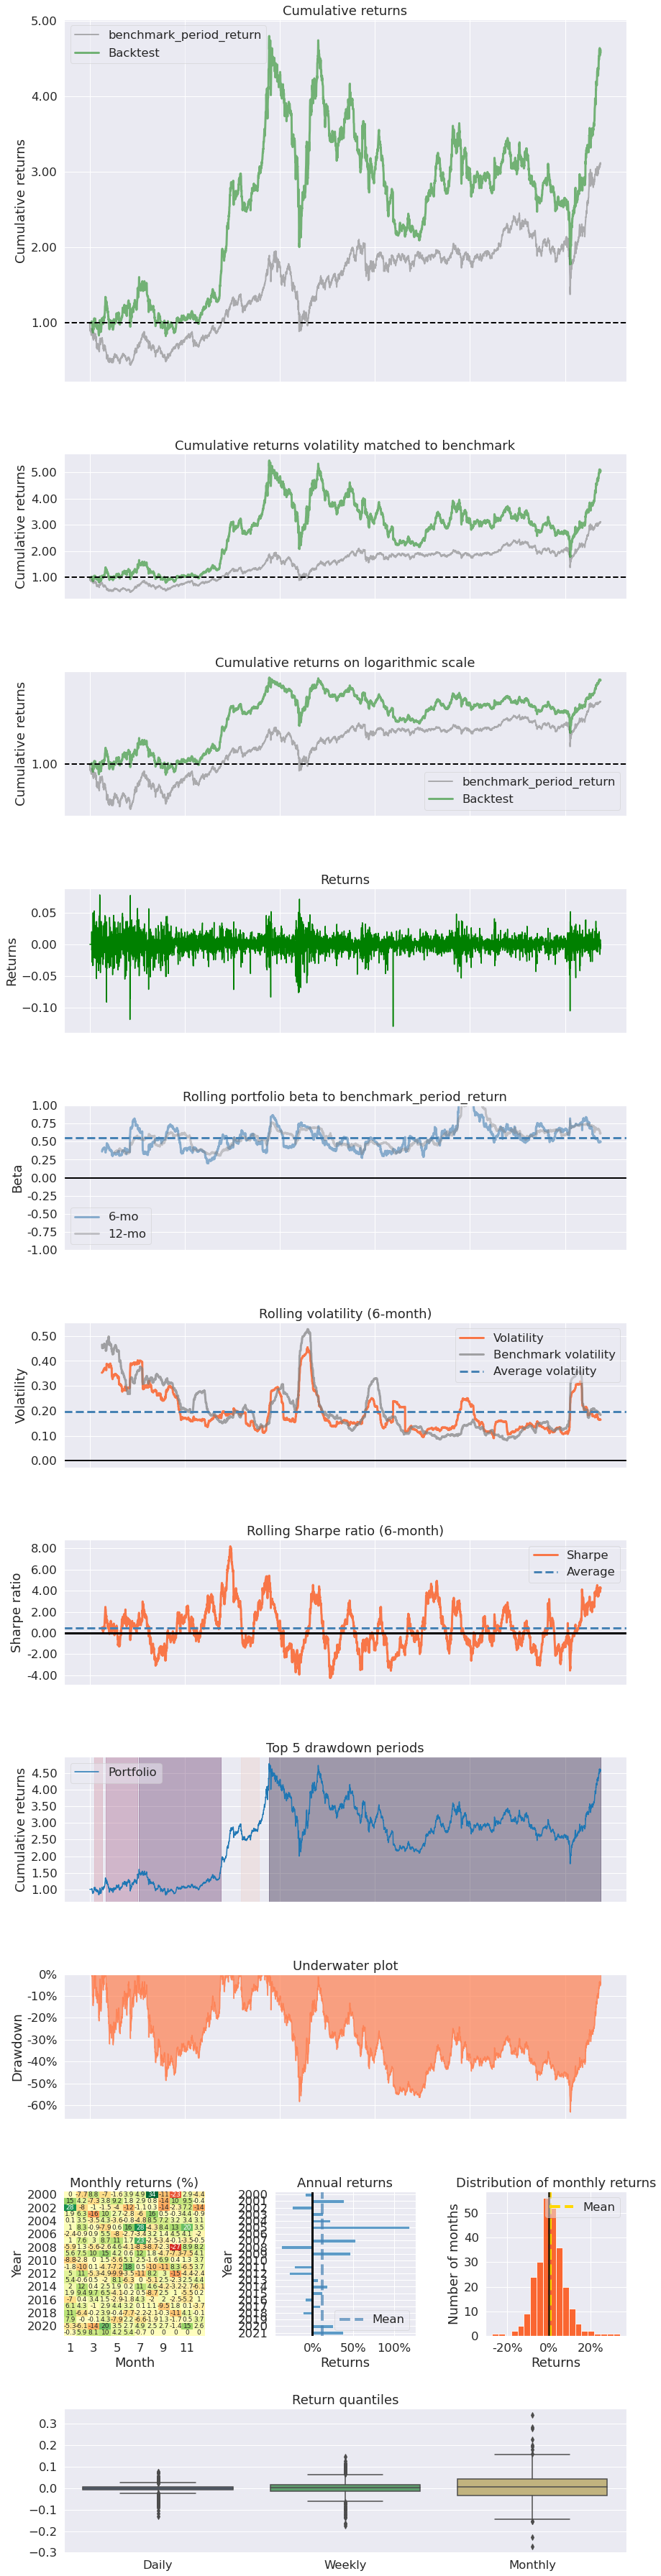

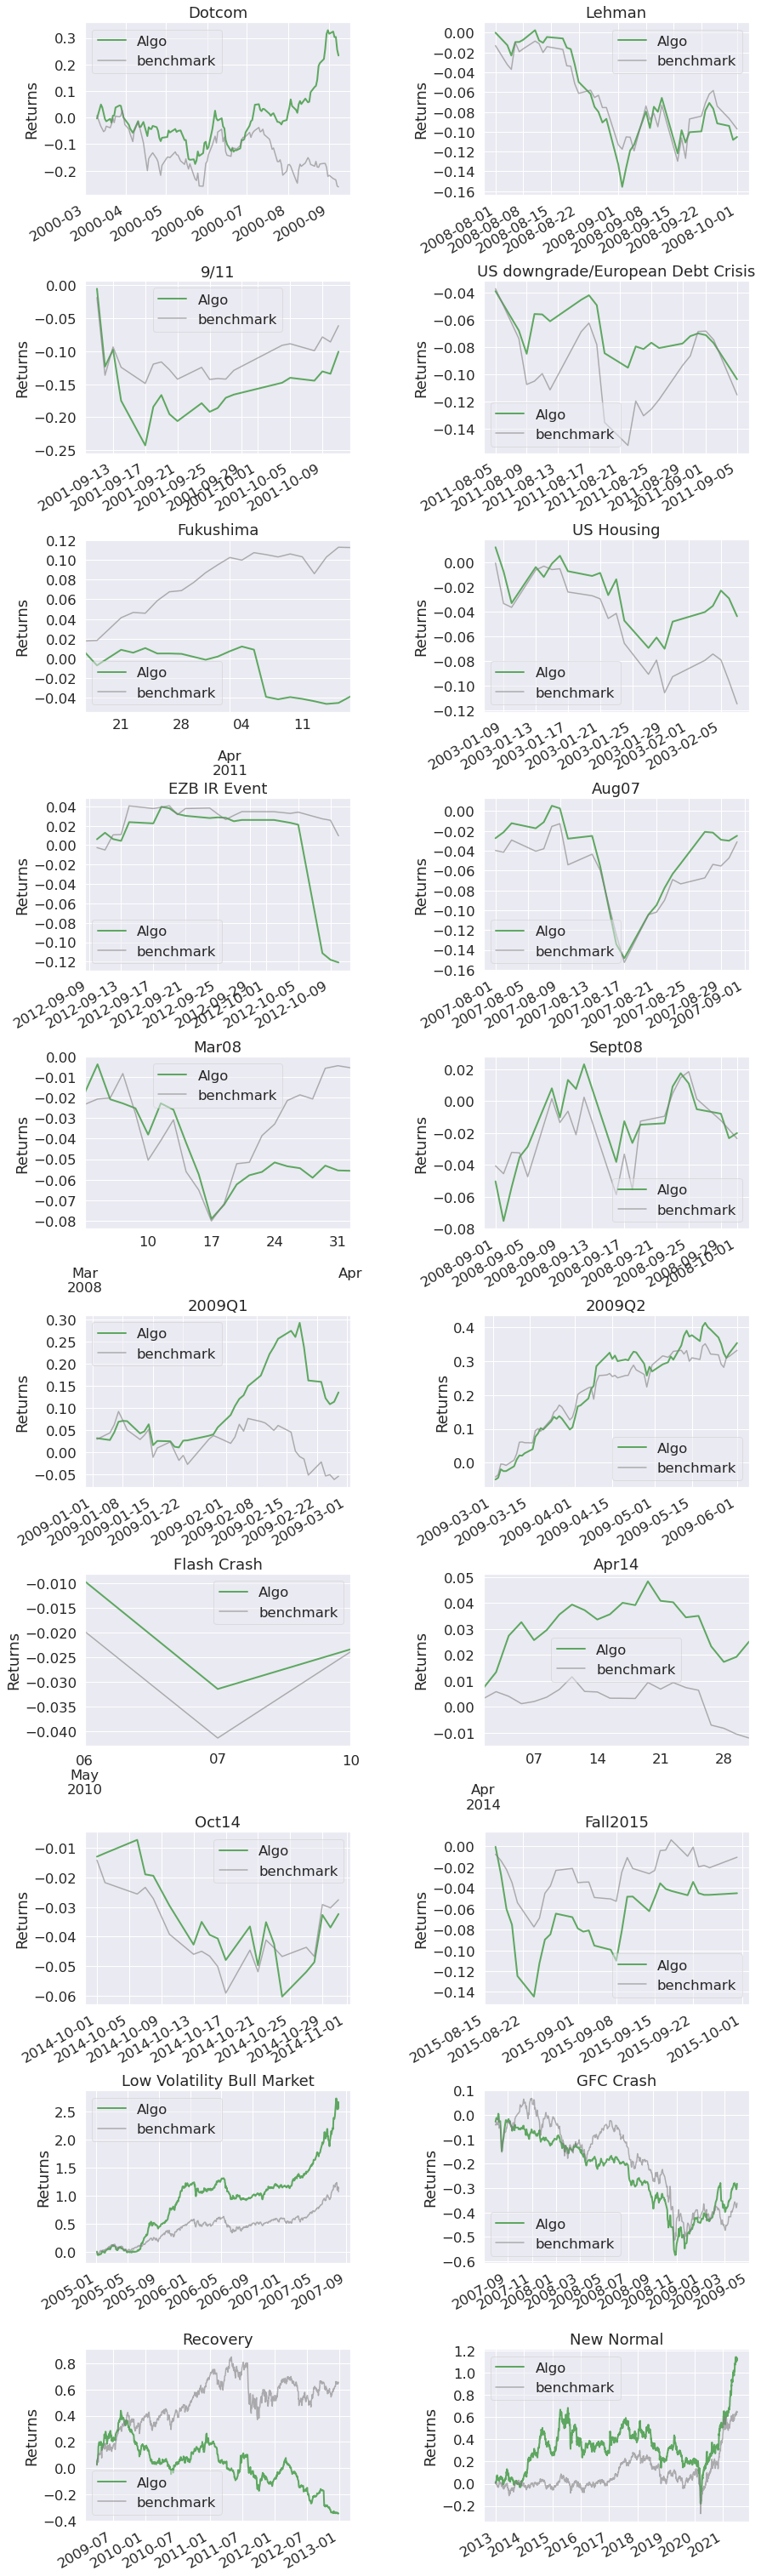

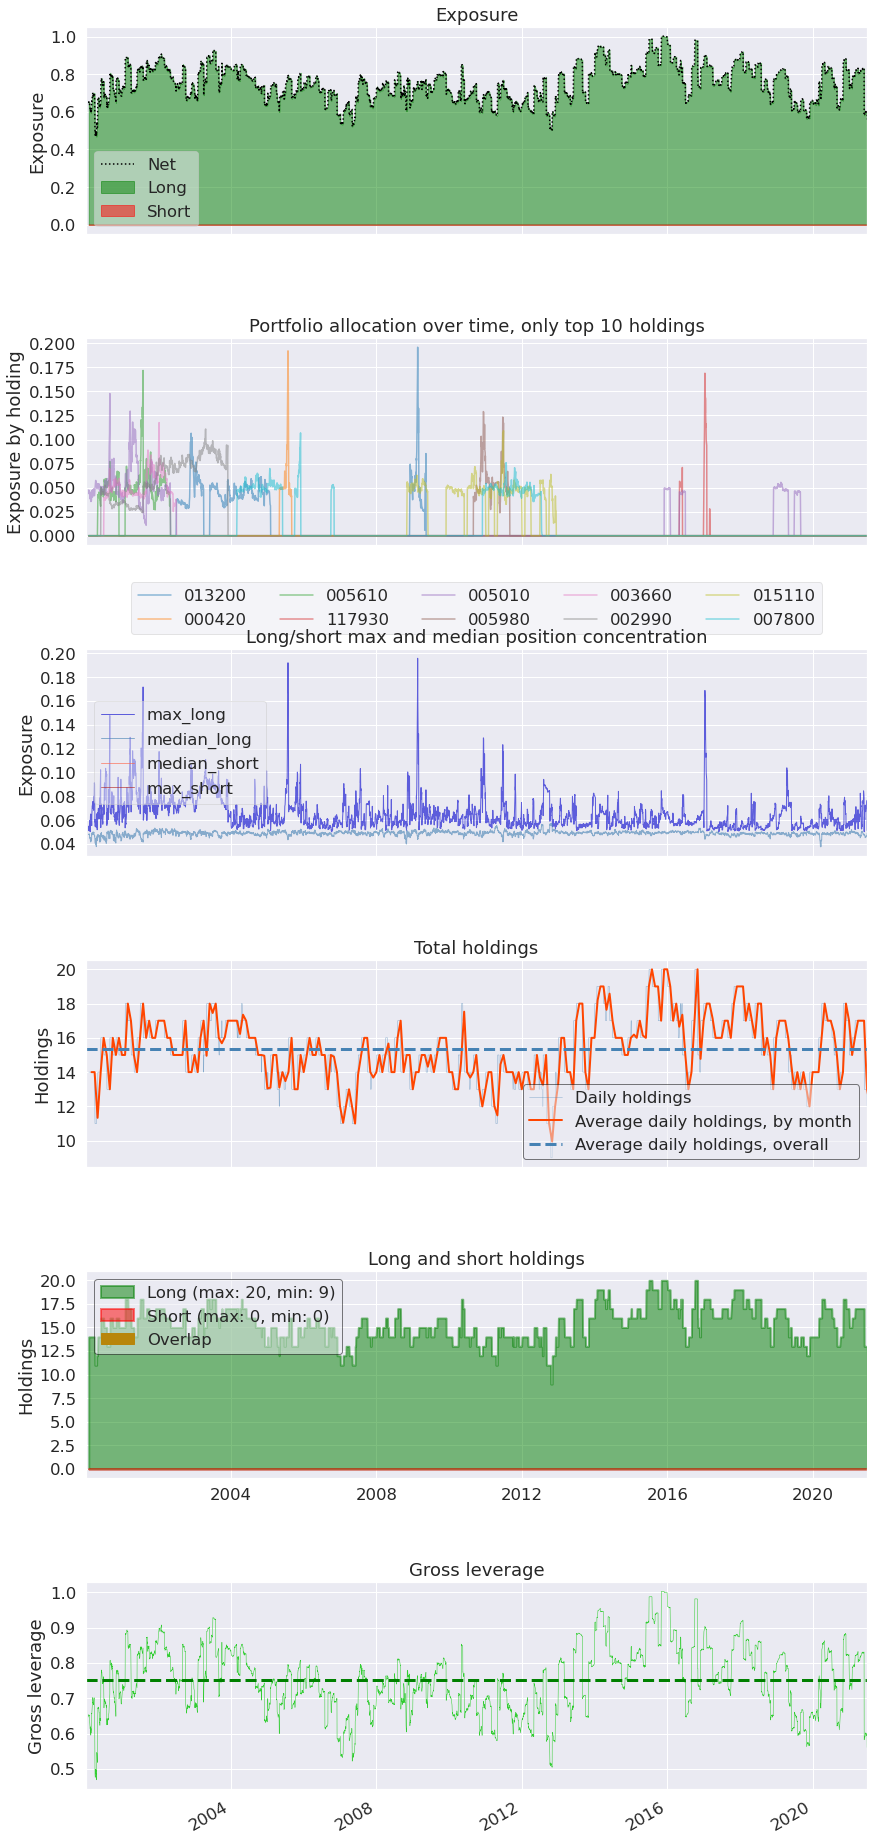

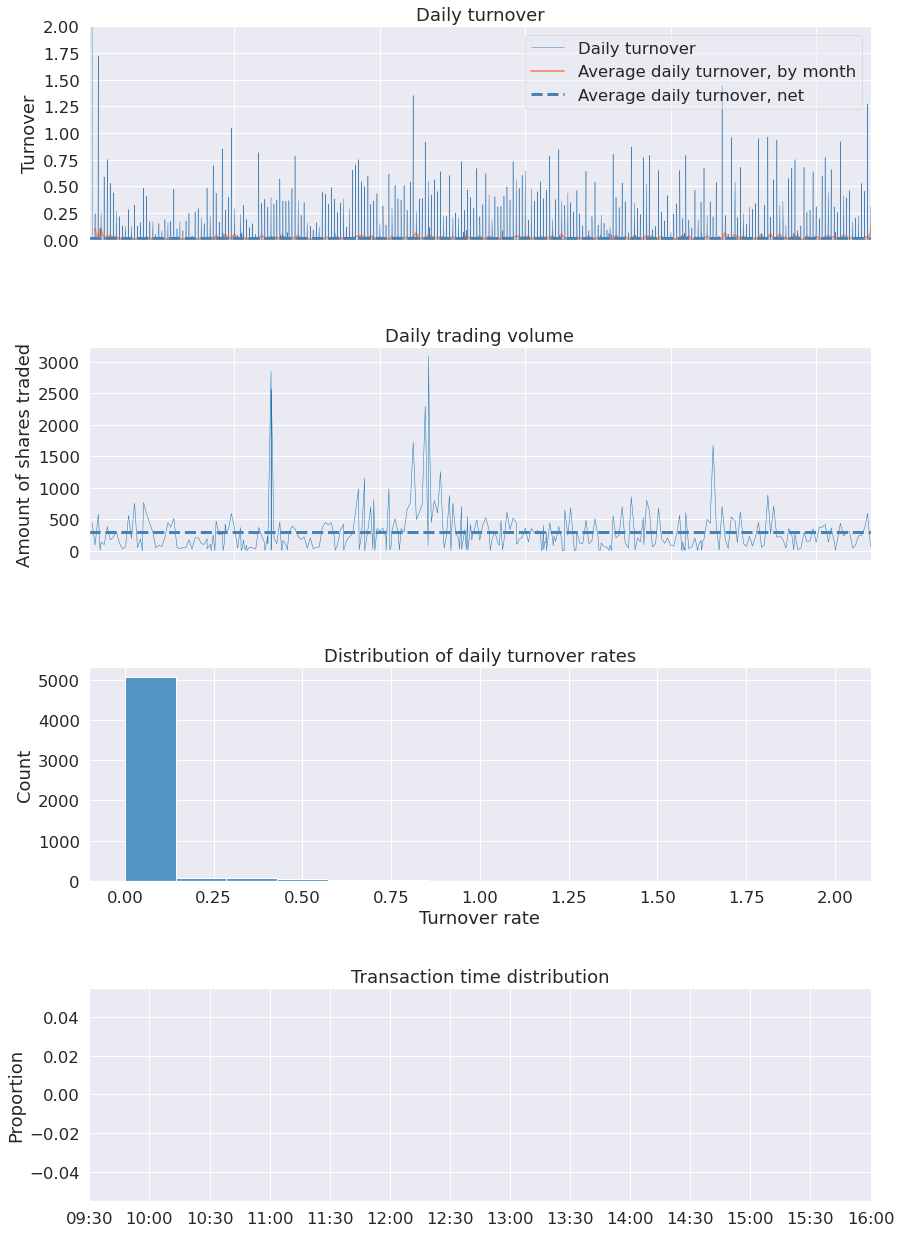

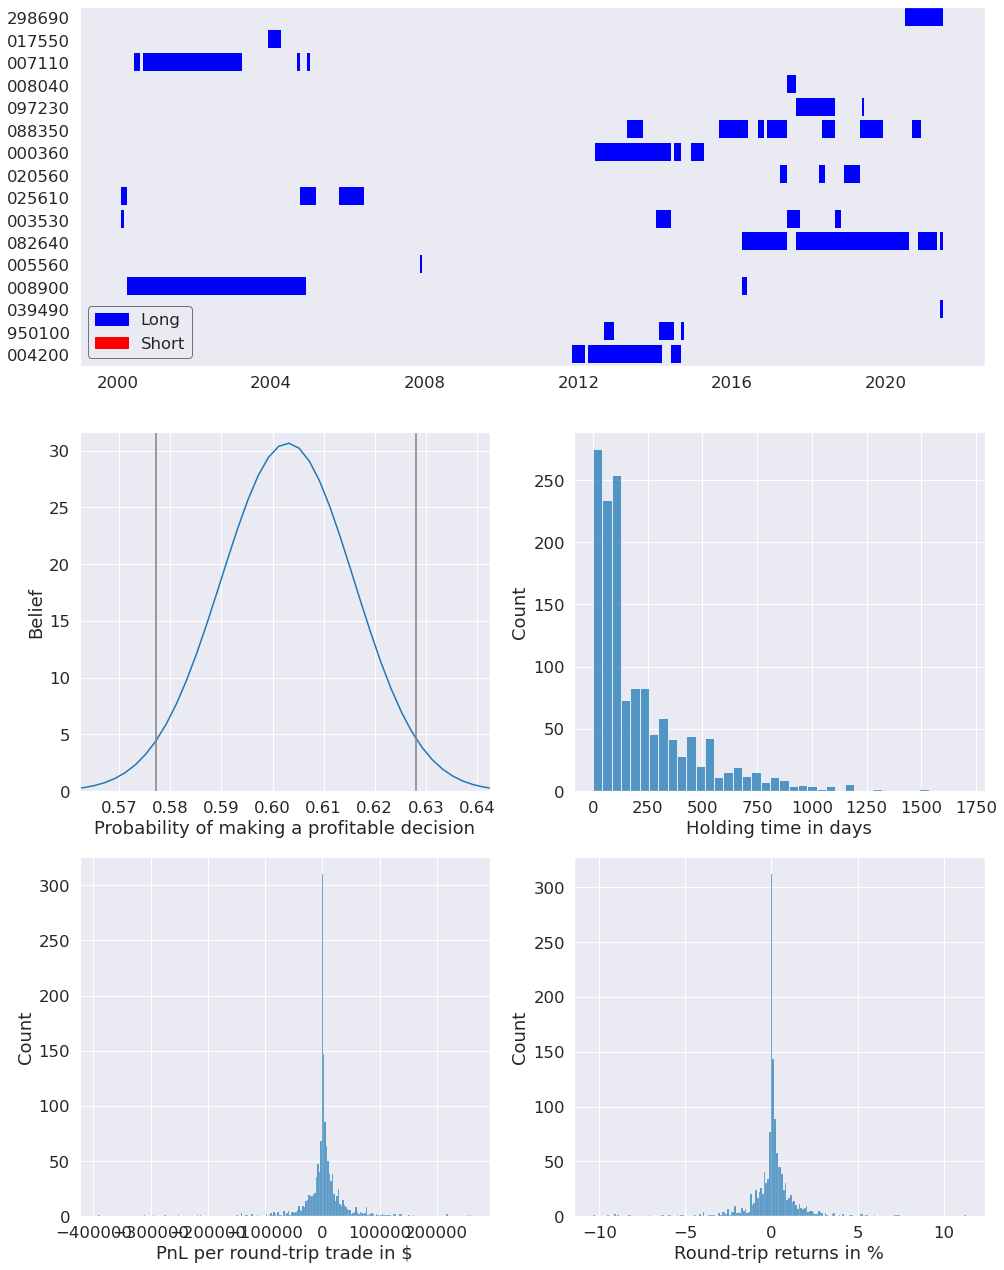

In [23]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)